# <center> 中风患者的发病模式是什么?</center>

<center> 仓库地址:(待补)</center>

**成员分工**

| 姓名 | 学号 | 分工 |
| :----:| :----: | :----: |
|刘晓晨|3220200920|选题调研，系统设计，文档编写|
|高佳蕊|3520200005|数据预处理，仓库管理，文档编写|
| 吴林涛|3520190042|设计算法，训练模型，模型优化|
|刘晓雨|3220200921|相关实验，可视化分析，文档编写|

## 一、介绍

### 1.1 问题背景及意义 

<p style="text-indent:2em">
据WHO(世界卫生组织)称：中风，亦称卒中，是全球第二大死亡原因，约占总死亡人数的11%。中风是一种严重可怕的心脑血管疾病，病情轻微，会导致不同程度的丧失劳动能力，病情严重的会有致残风险，甚至会有生命危险。事实上，80%的中风是可以预防的。在本工作中，我们试图将一些导致中风的关键指标形象化。这里的数据是从各种年龄组、性别、习惯和与健康有关的问题中抽取的。我们的目的是可视化各种健康和不健康习惯与中风之间的关系，并通过最佳模型和超调参数预测来中风概率。<br>

</p>



<p style="text-indent:2em">
    我们的目标是：利用最佳模型和超调参数预测脑卒中的发生概率，建立不同健康和不健康生活习惯与脑卒中的关系。
    </p>


### 1.2 数据来源

<p style="text-indent:2em">
我们选用来自kaggle的数据集[Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)。该数据集用于根据输入参数(如性别、年龄、各种疾病和吸烟状况)预测患者是否可能患中风。数据中的每一行都提供有关患者的相关信息。
</p>

### 1.3 库与工具

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import os
# os.add_dll_directory("d:\python385\Lib\site-packages\lightgbm\lib_lightgbm.dll")
import numpy as np
import pandas as pd
import re
import math
import string
from collections import Counter
import time
import shap  
import lime
import lime.lime_tabular
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from pywaffle import Waffle
%matplotlib inline
init_notebook_mode(connected= True)
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, 
                             auc, 
                             precision_score,
                             recall_score,
                             f1_score, 
                             roc_auc_score,
                             confusion_matrix)
from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     cross_val_score)

from sklearn.decomposition import PCA
from umap import UMAP
import pylab as pl
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     EditedNearestNeighbours,
                                     NearMiss)
from imblearn.over_sampling import (SMOTE,
                                    ADASYN)
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 二、数据预处理

<p style="text-indent:2em">
中风预测数据集数据的每一行提供了患者的相关信息，用于根据输入参数预测患者是否有可能患中风。本章节将进行数据属性分类、数据统计、属性分析和数据缺失处理。
</p>

In [2]:
# 载入数据并初步查看数据
df = pd.read_csv('C:\\Users\\i510400\\Desktop\\数据挖掘\\healthcare-dataset-stroke-data.csv', delimiter = ',', encoding = 'utf-8')
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


### 2.1 参数属性信息

In [3]:
# 基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


参数属性信息共有如下12个类别：
1. ID：参与者的身份号码；
2. 性别：参与者的性别，男、女或其他；
3. 年龄：参与者的年龄，0至100的整数；
4. 高血压：参与者的健康相关参数，有或无；
5. 心脏病：参与者的健康相关参数，有或无；
6. 婚姻状况：参与者的婚姻状况，是或否；
7. 工作类型：参与者工作场所的性质；
8. 居住类型：参与者的居住类型；
9. 平均葡萄糖水平：参与者的健康相关参数，平均葡萄糖水平；
10. BMI指数：参与者的身体质量指数；
11. 吸烟情况：参与者的习惯性信息，是或否；
12. 中风：参与者是否患有中风，是或否。


将属性分类为三种：
- 性别、是否已婚、工作类型、居住类型、是否吸烟属于分类特征；
- 高血压、心脏病、中风属于二进制数字特征；
- 年龄、平均葡萄糖水平、BMI指数属于连续数字特征。<br>
由数据处理结果可知，参与者人数为5110人。

### 2.2 数值属性

In [4]:
round (df.describe(exclude = 'object'), 2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.1,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.3,0.23,45.28,7.85,0.22
min,67.00,0.08,0.0,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.0,0.00,77.24,23.50,0.00
50%,36932.00,45.00,0.0,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.0,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.0,1.00,271.74,97.60,1.00


### 2.3 标称属性

In [5]:
round (df.describe(exclude = ['float', 'int64']),2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


### 2.4 缺失数据处理

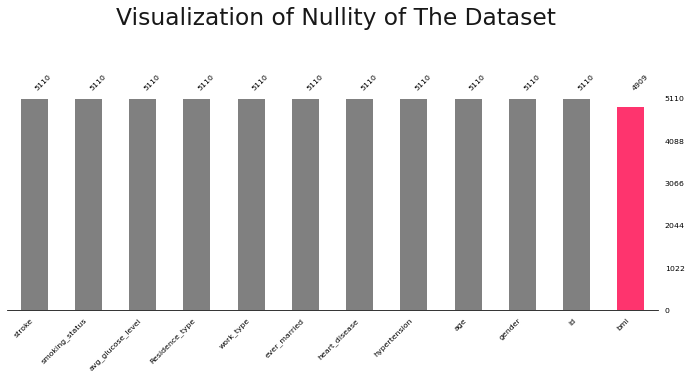

In [6]:
color = ['grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey', '#fe346e']
fig, ax = plt.subplots(figsize = (12,4), dpi = 70)
msno.bar(df,sort = 'descending',color = color, ax = ax, fontsize =8,labels = 'off',filter = 'top')
ax.text(1.5,1.35,'Visualization of Nullity of The Dataset',{'Size': 24,  'color':'black'},alpha = 0.9)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)
fig.show()

在给定的数据集中总共有5110个数据点。只有“bmi”特性有空值。

In [7]:
# 缺失数据计数
missing_values_count = df.isna().sum()

#统计缺失数据的比例
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()
percent_missing = round((total_missing/total_cells)*100,2)
print("Percentage of missing data from the dataset is : {}%".format(percent_missing))

Percentage of missing data from the dataset is : 0.33%


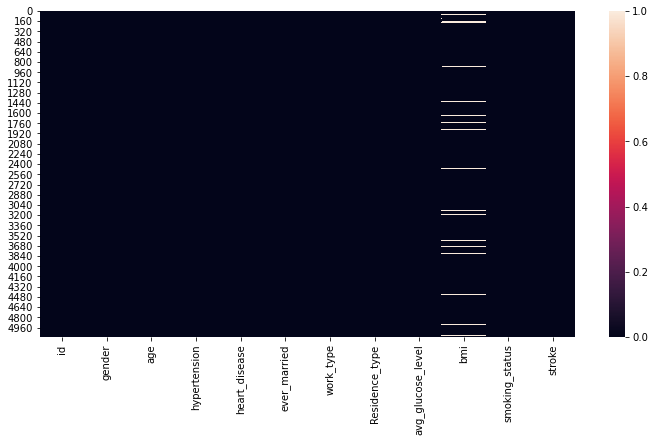

In [8]:
# 热图
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull())
plt.show()

由数据处理结果可知，BMI指数部分存在缺失，缺失人数为201人，占比0.33%。接下来，我们将中位数填入空缺位置。

In [9]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

In [10]:
# 补充之后的数据
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
# 数值变量的丢弃
df['bmi_cat'] = pd.cut(df['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df['age_cat'] = pd.cut(df['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df['glucose_cat'] = pd.cut(df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

## 三、数据初探索

### 3.1 总体患病比例

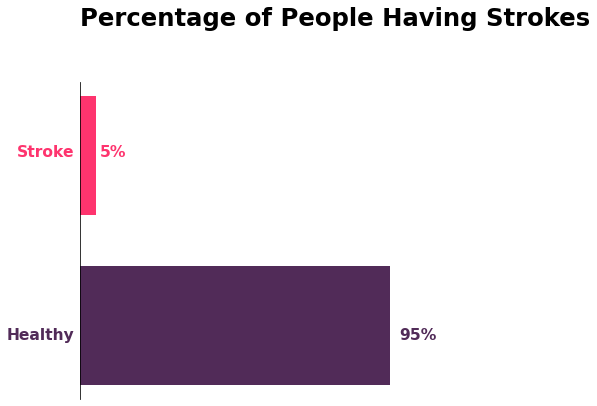

In [12]:
# 先分类
x = pd.DataFrame( df.groupby(['stroke'])['stroke'].count())

# 画图
fig, ax = plt.subplots(figsize = (6,6), dpi = 70)
ax.barh([1], x.stroke[1], height = 0.7, color = '#fe346e')
plt.text(-1150,-0.08, 'Healthy',{'weight':'bold','Size': '16','style':'normal', 'color':'#512b58'})
plt.text(5000,-0.08, '95%',{'weight':'bold' ,'size':'16','color':'#512b58'})
ax.barh([0], x.stroke[0], height = 0.7, color = '#512b58')
plt.text(-1000,1, 'Stroke', {'weight':'bold','Size': '16','style':'normal', 'color':'#fe346e'})
plt.text(300,1, '5%',{'weight':'bold','size':'16','color':'#fe346e'})
plt.text(0,1.77, 'Percentage of People Having Strokes' ,{'Size': '25','weight':'bold', 'color':'black'})
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

从分布中可以明显看出，根据我们的抽样数据，每100个人中就有5个人患有中风。 而且，这是一个高度不平衡的数据分布，该分布本身的无效准确度得分为95％，因此，如果采用任何模型，随机预测准确度可以达到95％。 所以，在对数据进行建模和训练时，必须进行过采样或欠采样以获得最佳结果。

### 3.2 分类变量的单变量分析

#### 3.2.1 对性别的分析

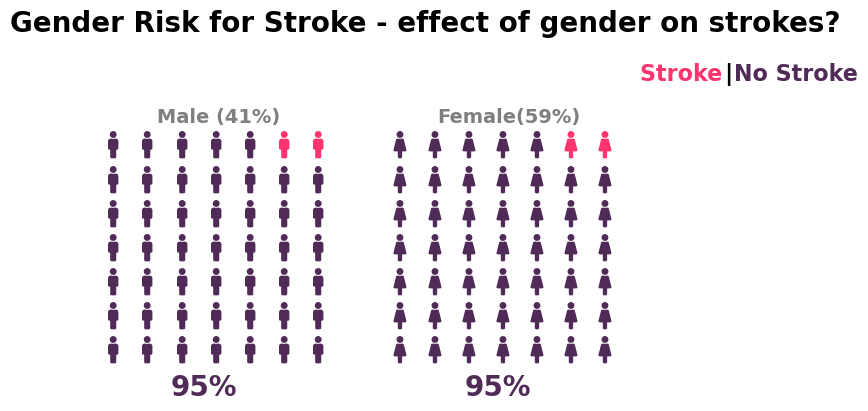

In [13]:
# 中风的与健康的
stroke_gen = df[df['stroke'] == 1]['gender'].value_counts()
healthy_gen = df[df['stroke'] == 0]['gender'].value_counts()
# 男性和女性
female = df['gender'].value_counts().values[0]
male =  df['gender'].value_counts().values[1]
# 中风的男性和女性数量
stroke_female = int(round (stroke_gen.values[0] / female * 100, 0))
stroke_male = int(round( stroke_gen.values[1] / male *100, 0))
# 健康的男性和女性的数量
healthy_female = int(round(healthy_gen.values[0] / female * 100, 0))
healthy_male = int(round(healthy_gen.values[1] / male *100, 0))
# 比例
female_per = int(round(female/(female+male) * 100, 0))
male_per = int(round(male/(female+male)* 100, 0))
# 画图
fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 dpi = 100,
                 
                 plots = {'121':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [healthy_male,stroke_male],
                            'colors' : ['#512b58','#fe346e'],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'male',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          '122' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[healthy_female,stroke_female],         
                              'colors' : ['#512b58','#fe346e'],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'female',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)
# 文字
fig.text(0., 0.8, 'Gender Risk for Stroke - effect of gender on strokes?', {'size':20, 'color':'black', 'weight':'bold'})
fig.text(0.23, 0.28, '{}%'.format(healthy_male), {'size':20,'weight':'bold' ,'color':'#512b58'},alpha = 1,)
fig.text(0.65, 0.28, '{}%'.format(healthy_female), {'size':20,'weight':'bold', 'color':'#512b58'}, alpha = 1)
fig.text(0.21, 0.67, 'Male ({}%)'.format(male_per), {'size':14,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.61, 0.67, 'Female({}%)'.format(female_per), { 'size':14,'weight':'bold', 'color':'black'}, alpha = 0.5)
fig.text(0.9,0.73, 'Stroke ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(1.02,0.73, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.035,0.73, 'No Stroke', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)
fig.show()

**从中我们可以看出，男性和女性中风的风险几乎是相同的。**

#### 3.2.2 对患有高血压的分析

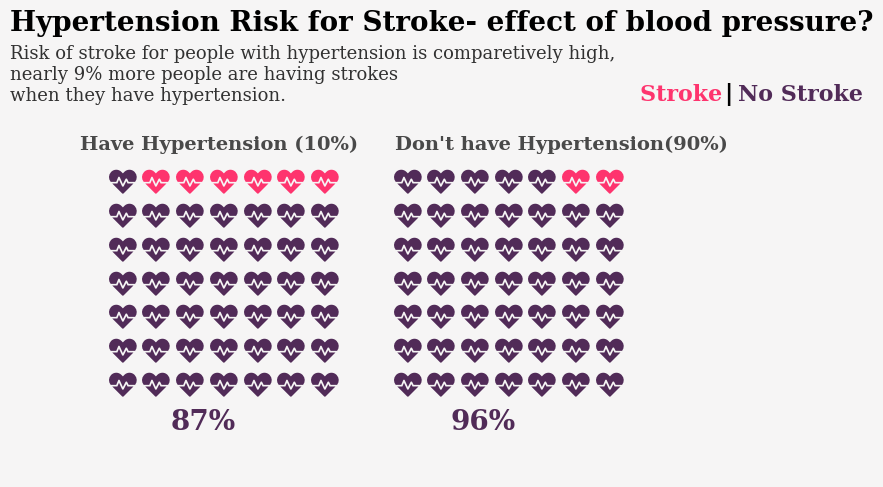

In [23]:
stroke_hyper = df[df['stroke'] == 1]['hypertension'].value_counts()
healthy_hyper = df[df['stroke'] == 0]['hypertension'].value_counts()

no = df['hypertension'].value_counts().values[0]
yes =  df['hypertension'].value_counts().values[1]

stroke_no = int(round (stroke_hyper.values[0] / no * 100, 0))
stroke_yes = int(round( stroke_hyper.values[1] / yes *100, 0))
healthy_no = int(round(healthy_hyper.values[0] / no * 100, 0))
healthy_yes = int(round(healthy_hyper.values[1] / yes *100, 0))

no_per = int(round(no/(no+yes) * 100, 0))
yes_per = int(round(yes/(no+yes)* 100, 0))




fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {'121':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_yes,healthy_yes],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'heartbeat',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':1,
                              'starting_location': 'NE'
                          },
                          
                          '122' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_no,healthy_no],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y':0.005,
                              'icons' : 'heartbeat',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':1,
                              'starting_location': 'NE'
                                                      
                           }
                         },
                   
)


fig.text(0., 0.85, 'Hypertension Risk for Stroke- effect of blood pressure?', {'font':'Serif', 'size':20, 'color':'black', 'weight':'bold'})
fig.text(0., 0.75, 'Risk of stroke for people with hypertension is comparetively high,\nnearly 9% more people are having strokes \nwhen they have hypertension. ', {'font':'Serif', 'size':13, 'color':'black', 'weight':'normal'},alpha = 0.8)
fig.text(0.24, 0.22, 'ooo', {'font':'Serif', 'size':16,'weight':'bold' ,'color':'#f6f5f5'})
fig.text(0.65, 0.22, 'ooo', {'font':'Serif', 'size':16,'weight':'bold', 'color':'#f6f5f5'})
fig.text(0.23, 0.28, '{}%'.format(healthy_yes), {'font':'Serif', 'size':20,'weight':'bold' ,'color':'#512b58'},alpha = 1,)
fig.text(0.63, 0.28, '{}%'.format(healthy_no), {'font':'Serif', 'size':20,'weight':'bold', 'color':'#512b58'}, alpha = 1)
fig.text(0.1, 0.68, 'Have Hypertension ({}%)'.format(yes_per), {'font':'Serif', 'size':14,'weight':'bold' ,'color':'black'},alpha = 0.7,)
fig.text(0.55, 0.68, "Don't have Hypertension({}%)".format(no_per), {'font':'Serif', 'size':14,'weight':'bold', 'color':'black'}, alpha = 0.7)
#fig.text(0., 0.8, 'Assumption was proven wrong', {'font':'Serif', 'size':24, 'color':'black', 'weight':'bold'})

fig.text(0.90,0.75, 'Stroke ', {'font': 'Serif','weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(1.02,0.75, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.04,0.75, 'No Stroke', {'font': 'Serif','weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)


fig.show()

#### 3.2.3 对患有心脏病的分析

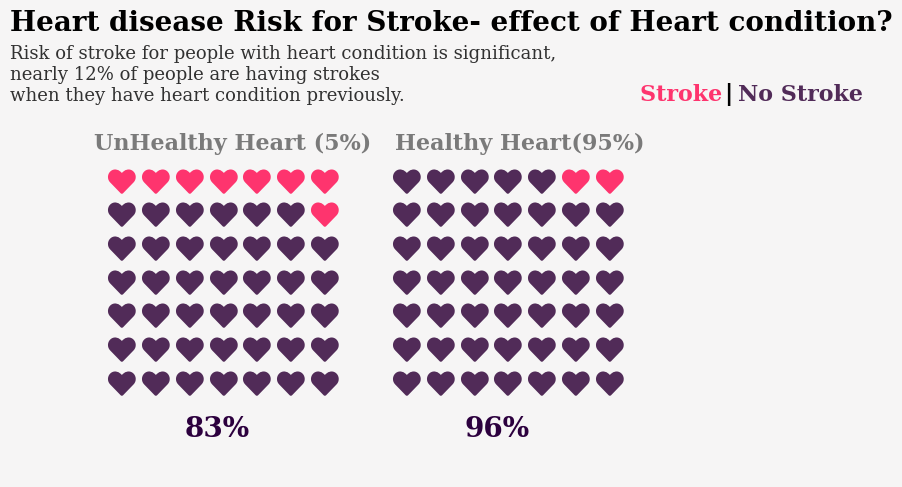

In [24]:
stroke_hyper = df[df['stroke'] == 1]['heart_disease'].value_counts()
healthy_hyper = df[df['stroke'] == 0]['heart_disease'].value_counts()

no = df['heart_disease'].value_counts().values[0]
yes =  df['heart_disease'].value_counts().values[1]

stroke_no = int(round (stroke_hyper.values[0] / no * 100, 0))
stroke_yes = int(round( stroke_hyper.values[1] / yes *100, 0))
healthy_no = int(round(healthy_hyper.values[0] / no * 100, 0))
healthy_yes = int(round(healthy_hyper.values[1] / yes *100, 0))

no_per = int(round(no/(no+yes) * 100, 0))
yes_per = int(round(yes/(no+yes)* 100, 0))




fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {'121':
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [stroke_yes,healthy_yes],
                            'colors' : ['#fe346e','#512b58'],
                              'vertical' : True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y': 0.005,
                              'icons' : 'heart',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                          },
                          
                          '122' :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[stroke_no,healthy_no],         
                              'colors' : ['#fe346e','#512b58'],
                              'vertical': True,
                              'interval_ratio_x': 0.005,
                              'interval_ratio_y':0.005,
                              'icons' : 'heart',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.8,
                              'starting_location': 'NE'
                                                      
                           }
                         },
                   
)


fig.text(0., 0.85, 'Heart disease Risk for Stroke- effect of Heart condition?', {'font':'Serif', 'size':20, 'color':'black', 'weight':'bold'})
fig.text(0., 0.75, 'Risk of stroke for people with heart condition is significant,\nnearly 12% of people are having strokes \nwhen they have heart condition previously. ', {'font':'Serif', 'size':13, 'color':'black', 'weight':'normal'}, alpha = 0.8)
fig.text(0.24, 0.22, 'ooo', {'font':'Serif', 'size':16,'weight':'bold' ,'color':'#f6f5f5'})
fig.text(0.65, 0.22, 'ooo', {'font':'Serif', 'size':16,'weight':'bold', 'color':'#f6f5f5'})
fig.text(0.25, 0.27, '{}%'.format(healthy_yes), {'font':'Serif', 'size':20,'weight':'bold' ,'color':'#2c003e'},alpha = 1,)
fig.text(0.65, 0.27, '{}%'.format(healthy_no), {'font':'Serif', 'size':20,'weight':'bold', 'color':'#2c003e'}, alpha = 1)
fig.text(0.12, 0.68, 'UnHealthy Heart ({}%)'.format(yes_per), {'font':'Serif', 'size':16,'weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.55, 0.68, "Healthy Heart({}%)".format(no_per), {'font':'Serif', 'size':16,'weight':'bold', 'color':'black'}, alpha = 0.5)
#fig.text(0., 0.8, 'Assumption was proven wrong', {'font':'Serif', 'size':24, 'color':'black', 'weight':'bold'})

fig.text(0.9,0.75, 'Stroke ', {'font': 'Serif','weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
fig.text(1.02,0.75, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.04,0.75, 'No Stroke', {'font': 'Serif','weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'#512b58'},alpha = 1)


fig.show()

## 四、可视化数据平衡与数据采样技术

选择SMOTE过采样数据进行建模，因为该技术生成的数据点的个数比例相等。

In [14]:
print('Inverse of Null Accuracy: ',249/(249+4861))
print('Null Accuracy: ',4861/(4861+249))

X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)
X_test.head(2)

Inverse of Null Accuracy:  0.0487279843444227
Null Accuracy:  0.9512720156555773


,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi
4688,Male,31.0,0,0,Self-employed,64.85,23.0
4478,Male,40.0,0,0,Self-employed,65.29,28.3


## 五、预测模型建立及训练

本节采用SVC,DecisionTree,AdaBoost,RandomForest,GradientBoosting,KNeighboors,LogisticRegression, XGBoost,LightGBM这9种分类模型分别对原始数据和过采样数据进行处理，得到它们的F1得分和AUC，然后对它们的实验结果进行可视化处理以及对比分析。

In [15]:
# final data preprocessing and preperation

df_copy = df.copy()
# feature log transformations 

df['age'] = df['age'].apply(lambda x: np.log(x+10)*3)
df['avg_glucose_level'] = df['avg_glucose_level'].apply(lambda x: np.log(x+10)*2)
df['bmi'] = df['bmi'].apply(lambda x: np.log(x+10)*2)



# preprocessing - label enconding and numerical value scaling
ohe = OneHotEncoder()
ss = StandardScaler()
le = LabelEncoder()
X = df.drop(['stroke','id'], axis = 1)
y = df['stroke']
ordinal = ['age_cat',  'glucose_cat', 'bmi_cat','hypertension', 'heart_disease'] # label enconding
nominal =  ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] 
numerical = ['age','bmi', 'avg_glucose_level'] 

## label encoding of ordinal categorical features
for col in ordinal:
    X[col] = le.fit_transform(X[col])
    
## normalizing with standard scaler of numerical features
X[numerical] = ss.fit_transform(X[numerical])

## norminal data one hot encoding for categorical features
temp = X.drop(columns = nominal)
dummies = pd.get_dummies(X[nominal])
X = pd.concat([temp,dummies], axis = 1)

In [16]:
# training and testing data split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, shuffle = True, random_state = 2021)

#smotere  sampling 
smote = SMOTE()
X_resample, y_resample = smote.fit_resample(X_train, y_train.ravel())

print('Shape of Training features: {}'.format(X_resample.shape))
print('Shape of Training targets: {}'.format(y_resample.shape))
print('Shape of Testing features: {}'.format(X_test.shape))
print('Shape of Testing targets: {}'.format(y_test.shape))

Shape of Training features: (7284, 24)
Shape of Training targets: (7284,)
Shape of Testing features: (1278, 24)
Shape of Testing targets: (1278,)


In [17]:
# Null accuracy Score for current data
NUll_acc = round (max(y_test.mean(), 1 - y_test.mean()), 2)

print('Null Accuracy Score for Current Data is {}'.format(NUll_acc))

Null Accuracy Score for Current Data is 0.95


In [18]:
def predictions(x_set,y_set):
    t1 = time.time()
    print('Classification Process Starts....')
    accuracy,precision,recall,f1,auc,conf_mat= [],[],[],[],[],[]
        
    random_state = 2021
    
    ##classifiers list 
    classifiers = []
    classifiers.append(SVC(random_state=random_state, probability = True))
    classifiers.append(DecisionTreeClassifier(random_state=random_state))
    classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state)))
    classifiers.append(RandomForestClassifier(random_state=random_state))
    classifiers.append(GradientBoostingClassifier(random_state=random_state))
    classifiers.append(KNeighborsClassifier())
    classifiers.append(LogisticRegression(random_state = random_state))
    classifiers.append(XGBClassifier(random_state = random_state,eval_metric = 'logloss',learning_rate = 0.054))
    classifiers.append(LGBMClassifier(random_state = random_state,learning_rate = 0.067))


    for classifier in classifiers:
        
        t =time.time()
        print('fitting on classifier with parameters: {}'.format(classifier))
        
        #classifier and fitting
        clf = classifier
        clf.fit(x_set,y_set)
        
        #predictions
        y_preds = clf.predict(X_test)
        y_probs = clf.predict_proba(X_test)
        
        # metrics
        accuracy.append((round(accuracy_score(y_test,y_preds),2))*100)
        precision.append((round(precision_score(y_test,y_preds),2))*100)
        recall.append((round(recall_score(y_test,y_preds),2))*100)
        f1.append((round(f1_score(y_test,y_preds),2))*100)
        auc.append((round (roc_auc_score(y_test,y_probs[:,1]), 2))*100)
        conf_mat.append(confusion_matrix(y_test,y_preds))
        
        elapsed = time.time() - t
        print('Done and elapsed time is {}seconds'.format(round(elapsed,3)))
        print('\n')
    results_df = pd.DataFrame({"Accuracy Score":accuracy,"Precision Score":precision,
                        "Recall Score":recall, "f1 Score":f1,"AUC Score":auc,
                        "Confusion Matrix":conf_mat,
                        "Algorithm":["SVC","DecisionTree","AdaBoost",
                                     "RandomForest","GradientBoosting",
                                     "KNeighboors","LogisticRegression", "XGBoost"
                                      , "LightGBM"]})
    
    results_df = (results_df.sort_values(by = 'Algorithm', ascending = False)
                  .reset_index(drop =  True))
    t2 = time.time() - t1
    print('\nClassification is Completed and results are strored in dataframe.\ntotal time elapsed is {}seconds'.format(t2))
    print('***************************************************************\n\n')
    
    return results_df

In [19]:
orig_results = predictions(X_train,y_train)

Classification Process Starts....
fitting on classifier with parameters: SVC(probability=True, random_state=2021)
Done and elapsed time is 1.083seconds


fitting on classifier with parameters: DecisionTreeClassifier(random_state=2021)
Done and elapsed time is 0.02seconds


fitting on classifier with parameters: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021))
Done and elapsed time is 0.021seconds


fitting on classifier with parameters: RandomForestClassifier(random_state=2021)
Done and elapsed time is 0.281seconds


fitting on classifier with parameters: GradientBoostingClassifier(random_state=2021)
Done and elapsed time is 0.413seconds


fitting on classifier with parameters: KNeighborsClassifier()
Done and elapsed time is 0.201seconds


fitting on classifier with parameters: LogisticRegression(random_state=2021)
Done and elapsed time is 0.033seconds


fitting on classifier with parameters: XGBClassifier(base_score=None, booster=None, colsample_bylevel=Non

In [20]:
resamp_results = predictions(X_resample,y_resample)

Classification Process Starts....
fitting on classifier with parameters: SVC(probability=True, random_state=2021)
Done and elapsed time is 4.836seconds


fitting on classifier with parameters: DecisionTreeClassifier(random_state=2021)
Done and elapsed time is 0.033seconds


fitting on classifier with parameters: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021))
Done and elapsed time is 0.036seconds


fitting on classifier with parameters: RandomForestClassifier(random_state=2021)
Done and elapsed time is 0.52seconds


fitting on classifier with parameters: GradientBoostingClassifier(random_state=2021)
Done and elapsed time is 0.819seconds


fitting on classifier with parameters: KNeighborsClassifier()
Done and elapsed time is 0.372seconds


fitting on classifier with parameters: LogisticRegression(random_state=2021)
Done and elapsed time is 0.058seconds


fitting on classifier with parameters: XGBClassifier(base_score=None, booster=None, colsample_bylevel=Non

In [21]:
def multi_visualize(data, vmin = -0.5, vmax = 1):
    fig = plt.figure(figsize =(24,24))
    gs = fig.add_gridspec(8,6)
    gs.update(wspace = 0.2, hspace = 0.1)
    
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    
    ax4 = fig.add_subplot(gs[1,0])
    ax5 = fig.add_subplot(gs[1,1])
    ax6 = fig.add_subplot(gs[1,2])
    
    ax7 = fig.add_subplot(gs[2,0])
    ax8 = fig.add_subplot(gs[2,1])
    ax9 = fig.add_subplot(gs[2,2])
    
    ax10 = fig.add_subplot(gs[0,3])
    ax11 = fig.add_subplot(gs[0,4])
    ax12 = fig.add_subplot(gs[0,5])
    
    ax13 = fig.add_subplot(gs[1,3])
    ax14 = fig.add_subplot(gs[1,4])
    ax15 = fig.add_subplot(gs[1,5])
    
    ax16 = fig.add_subplot(gs[2,3])
    ax17 = fig.add_subplot(gs[2,4])
    ax18 = fig.add_subplot(gs[2,5])
    
    
    axes1 = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    axes2 = [ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18]
    
    axes = [axes1,axes2]
    
    fig.patch.set_facecolor('#f6f5f5')
    
    # setting of axes; visibility of axes and spines turn off
    for ax_list in axes:
        for ax in ax_list:
            ax.axes.get_yaxis().set_visible(False)
            ax.axes.get_xaxis().set_visible(False)
            ax.set_facecolor('#f6f5f5')

    colors = ['#512b58','#fe346e']
    colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    
    
    for ax_list in axes:
        
        if ax_list == axes1:
            res_df = data[0]
        else:
            res_df = data[1]
        
        
        alg = res_df['Algorithm']
        cf = res_df['Confusion Matrix']

        auc = res_df['AUC Score']
        f1 = res_df['f1 Score']
        forig = data[0]['f1 Score']
        fresam = data[1]['f1 Score']
        
        n = 0
        for ax in ax_list:
            if n >= len(cf):
                continue
            cf_mat = cf[n]
            
            #### annotations
            labels = ['True Neg','False Pos','False Neg','True Pos']
            counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
            percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten()/np.sum(cf_mat)]
            
            #### final annotations
            label = (np.array([f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(labels,counts,percentages)])).reshape(2,2)
            
            #### heatmap
            sns.heatmap(data = cf_mat, vmin = vmin, vmax =vmax, cmap = ['grey'],linewidth=2,linecolor = '#f6f5f5',
               ax = ax, annot = label, fmt ='', cbar = False, annot_kws = {'size':10, 'color':'white','weight':'bold'}, alpha =0.8)
            
            #### subtitle
            if ax_list == axes1:
                ax.text(0,-0,'{}'.format(alg[n]),{'size':12, 'color':'black', 'weight':'bold'})
            else:
                ax.text(0,-0,'SMOTE {}'.format(alg[n]),{'size':12, 'color':'black', 'weight':'bold'})
           
        
            #### Auc and F1 score plotting
            
            if ax_list == axes2:
                if (fresam[n] > forig[n]) & (auc[n] > 75):
                    ax.scatter( 1 , 1 , s = 3500, c = '#fe346e')
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'size':12, 'color':'black', 'weight':'bold'})
                else:
                    ax.scatter( 1 , 1 , s = 3500, c = 'white')
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'size':12, 'color':'black', 'weight':'bold'})
               
            else:
                if (forig[n] > 5 ) & (auc[n] > 75):
                    ax.scatter( 1 , 1 , s = 3500, c = '#512b58', alpha = 0.9)
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'size':12, 'color':'white', 'weight':'bold'})
                else:
                    ax.scatter( 1 , 1 , s = 3500, c = 'white')
                    ax.text(0.75,1.1, ' F1: {}\nAUC: {}'.format(int(round(f1[n],1)), int(round(auc[n],1))),{'size':12, 'color':'black', 'weight':'bold'})
            
           
            n +=1
        if ax_list == axes1:
            ax1.text(0,-0.55,'Visualization of Results with - Original Data',{'size':24, 'color':'black', 'weight':'bold'},)
        else:
            ax10.text(0,-0.55,'Visualization of Results with - Oversampled Data',{'size':24, 'color':'black', 'weight':'bold'}, alpha = 0.9)
            
            
    fig.show()

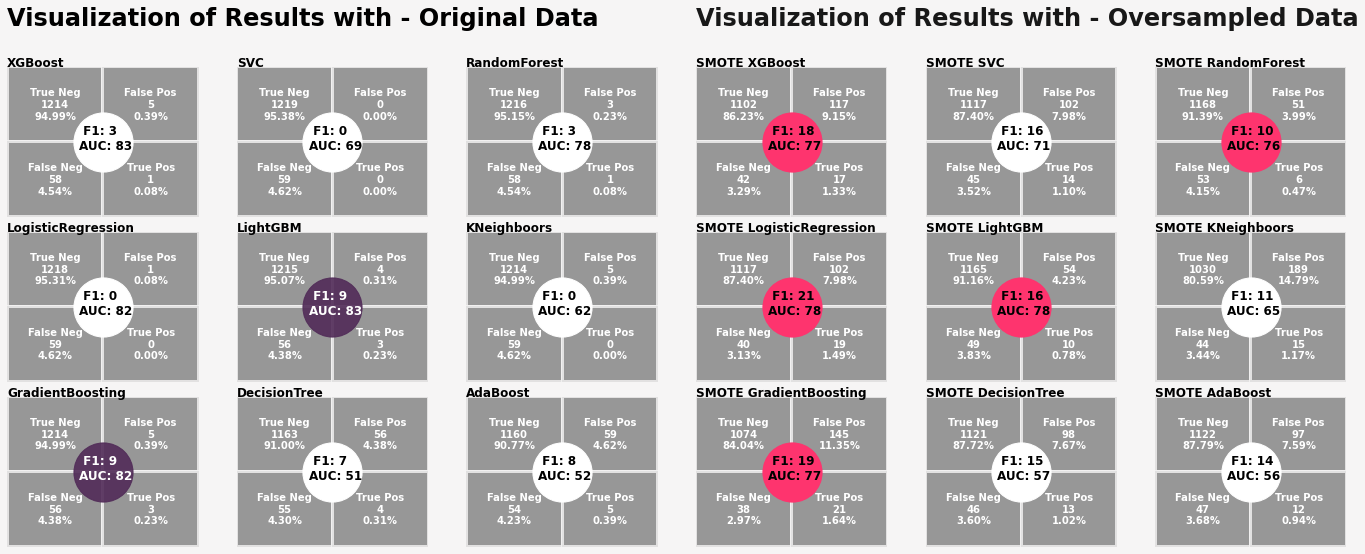

In [22]:
multi_visualize(data = [orig_results, resamp_results], vmin=30,vmax = 100)

上图分为两个部分，左半部分是原始数据的可视化结果，右半部分是过采样数据的可视化结果,从可视化中可以清楚地看到，过采样数据比原始数据具有更好的预测分数。原始数据中只有采用LightGBM和GradientBoosting这两种分类方法的结果F1分数大于5且AUC达到了75%以上，而过采样数据中9种分类方法的F1分数都在10以上且有XGBoost、RandomForest、LogisticRegression、LightGBM和GradientBoosting5种分类方法处理过的结果对比原始数据，它们的F1分数要高很多并且AUC达到了75%以上。